In [34]:
#Installing necessary packages

%pip install scipy
%pip install seaborn
%pip install statsmodels
%pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Importing Libraries and downloading nltk datasets

import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
from scipy.stats import f_oneway, shapiro, levene, kruskal
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
import re
import nltk 
import nltk as nlp

nltk.download("stopwords") 
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
import numpy as np

### Reading and ensuring consistency of data

In [2]:
# Reading songs data

combined_df = pd.read_csv('D:/Disseratation_data/combined_song_data.csv')

In [3]:
# Type casting Date and release_date column to date datatype

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['release_date'] = pd.to_datetime(combined_df['release_date'], format='ISO8601')

In [4]:
# Listing the columns in combined_df dataframe

combined_df.columns

Index(['rank', 'uri', 'artist_names', 'track_name', 'source', 'peak_rank',
       'previous_rank', 'days_on_chart', 'streams', 'Date', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'album_type', 'popularity', 'release_date'],
      dtype='object')

In [5]:
combined_df.shape

(292200, 30)

In [6]:
# Selecting the first five rows of the dataframe

combined_df.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,Date,...,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,album_type,popularity,release_date
0,1,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,1,89,334456,2019-01-01,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17
1,1,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,1,90,421463,2019-01-02,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17
2,1,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,1,91,418099,2019-01-03,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17
3,1,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,1,92,437177,2019-01-04,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17
4,1,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,1,93,424643,2019-01-05,...,133.002,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17


### Preprocessing data for analysis

In [7]:
# Ensuring no columns have null values and printing in descending order

combined_df.isna().sum().sort_values(ascending=False).head()

rank              0
uri               0
popularity        0
album_type        0
time_signature    0
dtype: int64

In [8]:
# Reading uk covid data

uk_covid = pd.read_csv('D:/Disseratation_data/uk_covid_data.csv')

In [9]:
# Subsetting data to select only the required columns

uk_covid = uk_covid[['date', 'new_cases', 
       'new_cases_per_million', 'new_deaths', 'new_deaths_per_million'
       ]]

In [10]:
# Typing date column to date datatype

uk_covid['date'] = pd.to_datetime(uk_covid['date'])

In [11]:
uk_covid.columns

Index(['date', 'new_cases', 'new_cases_per_million', 'new_deaths',
       'new_deaths_per_million'],
      dtype='object')

In [12]:
# Listing columns based on null values in descending order

uk_covid.isna().sum().sort_values(ascending=False)

date                      0
new_cases                 0
new_cases_per_million     0
new_deaths                0
new_deaths_per_million    0
dtype: int64

In [13]:
# Function to return the most frequent text in columns

def text_extract(x):
    return x.mode().iloc[0]


In [14]:
# Grouping and aggregating data from combined_df by 'uri' to derive song properties of each unique song

song_properties_df = combined_df.groupby('uri').agg(
    artist_names = ('artist_names', text_extract),
    track_name = ('track_name', text_extract),
    source = ('source', text_extract),
    album_type = ('album_type', text_extract),
    release_date = ('release_date', text_extract),
    peak_rank = ('peak_rank', 'min'),
    streams = ('streams', 'max'),
    danceability = ('danceability', 'mean'),
    energy = ('energy', 'mean'),
    key =  ('key', 'mean'),
    loudness =  ('loudness', 'mean'), 
    mode =  ('mode', 'mean'),
    speechiness =  ('speechiness', 'mean'),  
    acousticness =  ('acousticness', 'mean'),
    instrumentalness =  ('instrumentalness', 'mean'),
    liveness =  ('liveness', 'mean'),
    valence =  ('valence', 'mean'),
    tempo =  ('tempo', 'mean'),
    duration_ms =  ('duration_ms', 'mean'),
    time_signature =  ('time_signature', 'mean'),
    days_on_chart = ('days_on_chart', 'max'),
    popularity = ('popularity', 'mean')
).reset_index()

In [15]:
# Selecting the first date each song reached it's peak rank

for i in song_properties_df['uri'].values:
    song_properties_df.loc[song_properties_df['uri'] == i, 'Date'] = combined_df.loc[
    (combined_df['uri'] == i) & 
    (combined_df['peak_rank'] == song_properties_df[song_properties_df['uri'] == i]['peak_rank'].iloc[0])
    ]['Date'].iloc[0]


In [16]:
# Listing the columns of the newly created dataframe

song_properties_df.columns

Index(['uri', 'artist_names', 'track_name', 'source', 'album_type',
       'release_date', 'peak_rank', 'streams', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'days_on_chart', 'popularity', 'Date'],
      dtype='object')

In [17]:
# Checking the shape of the dataframe

song_properties_df.shape

(6473, 24)

In [18]:
# Printing the first five rows of the dataframe

song_properties_df.head()

,uri,artist_names,track_name,source,album_type,release_date,peak_rank,streams,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,days_on_chart,popularity,Date
0,spotify:track:003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,album,2004-01-01,9,279141,0.352,0.911,...,0.001210,0.000000,0.0995,0.236,148.033,222973.0,4.0,2187,87.0,2021-12-31
1,spotify:track:00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,single,2021-11-05,13,200036,0.687,0.781,...,0.036100,0.000000,0.0755,0.688,97.014,193507.0,4.0,108,78.0,2021-11-08
2,spotify:track:00ETaeHUQ6lops3oWU1Wrt,"Kygo, Donna Summer",Hot Stuff,RCA Records Label,single,2020-09-18,121,64078,0.681,0.773,...,0.019000,0.000001,0.1100,0.429,119.961,199008.0,4.0,1,67.0,2020-09-18
3,spotify:track:00Mb3DuaIH1kjrwOku9CGU,Avril Lavigne,Sk8er Boi,Arista,album,2002-06-04,109,56078,0.487,0.900,...,0.000068,0.000000,0.3580,0.484,149.937,204000.0,4.0,2,79.0,2019-04-11
4,spotify:track:00R0fEFZGb5hyTgF1nrRCq,"Busta Rhymes, Kendrick Lamar",Look Over Your Shoulder (feat. Kendrick Lamar),"The Conglomerate Entertainment, Inc. / EMPIRE",album,2020-10-30,168,64190,0.600,0.887,...,0.043800,0.000000,0.6800,0.681,77.896,248811.0,4.0,1,53.0,2020-10-30


In [19]:
# Creating new column nostalgia where if the current date is more than three years old of the songs release, it is flagged as nostalgic

combined_df.loc[:, 'nostalgia'] = combined_df.apply(lambda row: 1 if (row['Date'] - row['release_date']).days > 1095 else 0, axis=1)

In [20]:
# Subsetting selected columns

selected_df = combined_df[['rank', 'peak_rank', 'streams', 'Date', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'release_date', 'nostalgia']]
selected_df.head()

,rank,peak_rank,streams,Date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date,nostalgia
0,1,1,334456,2019-01-01,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.0,0.166,0.628,133.002,187436,4,2018-08-17,0
1,1,1,421463,2019-01-02,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.0,0.166,0.628,133.002,187436,4,2018-08-17,0
2,1,1,418099,2019-01-03,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.0,0.166,0.628,133.002,187436,4,2018-08-17,0
3,1,1,437177,2019-01-04,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.0,0.166,0.628,133.002,187436,4,2018-08-17,0
4,1,1,424643,2019-01-05,0.719,0.704,1,-4.724,1,0.0476,0.0691,0.0,0.166,0.628,133.002,187436,4,2018-08-17,0


In [21]:
# Creating three dataframes based on the lockdown period in the UK and selecting the equal number of days for each of the three periods
# Lockdown started in the UK on 26 March 2020 and ended on 8 March 2021 

before_ld = selected_df[(selected_df['Date'] >= '03/26/2019') & (selected_df['Date'] < '26/03/2020' )]
during_ld = selected_df[(selected_df['Date'] >= '03/26/2020') &  (selected_df['Date'] <= '03/08/2021')]
after_ld = selected_df[(selected_df['Date'] >= '03/26/2021') &  (selected_df['Date'] <= '03/08/22')]

In [22]:
# Performing sentiment analysis on track name

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):

    words = nltk.word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

song_properties_df['processed_track_name'] = song_properties_df['track_name'].apply(preprocess_text)
song_properties_df['sentiment'] = song_properties_df['processed_track_name'].apply(lambda x: TextBlob(x).sentiment.polarity)
song_properties_df.head()


,uri,artist_names,track_name,source,album_type,release_date,peak_rank,streams,danceability,energy,...,liveness,valence,tempo,duration_ms,time_signature,days_on_chart,popularity,Date,processed_track_name,sentiment
0,spotify:track:003vvx7Niy0yvhvHt4a68B,The Killers,Mr. Brightside,Island Records,album,2004-01-01,9,279141,0.352,0.911,...,0.0995,0.236,148.033,222973.0,4.0,2187,87.0,2021-12-31,brightsid,0.000000
1,spotify:track:00Blm7zeNqgYLPtW6zg8cj,"Post Malone, The Weeknd",One Right Now (with The Weeknd),Republic Records,single,2021-11-05,13,200036,0.687,0.781,...,0.0755,0.688,97.014,193507.0,4.0,108,78.0,2021-11-08,one right weeknd,0.285714
2,spotify:track:00ETaeHUQ6lops3oWU1Wrt,"Kygo, Donna Summer",Hot Stuff,RCA Records Label,single,2020-09-18,121,64078,0.681,0.773,...,0.1100,0.429,119.961,199008.0,4.0,1,67.0,2020-09-18,hot stuff,0.250000
3,spotify:track:00Mb3DuaIH1kjrwOku9CGU,Avril Lavigne,Sk8er Boi,Arista,album,2002-06-04,109,56078,0.487,0.900,...,0.3580,0.484,149.937,204000.0,4.0,2,79.0,2019-04-11,boi,0.000000
4,spotify:track:00R0fEFZGb5hyTgF1nrRCq,"Busta Rhymes, Kendrick Lamar",Look Over Your Shoulder (feat. Kendrick Lamar),"The Conglomerate Entertainment, Inc. / EMPIRE",album,2020-10-30,168,64190,0.600,0.887,...,0.6800,0.681,77.896,248811.0,4.0,1,53.0,2020-10-30,look shoulder feat kendrick lamar,0.000000


### Exploratory Data Analysis

In [23]:
# Statistical summary of the numerical columns in combined_df

selected_df.select_dtypes(include=['number']).describe()

,rank,peak_rank,streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,nostalgia
count,292200.000000,292200.000000,2.922000e+05,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000,292200.000000
mean,100.500000,31.401848,1.015967e+05,0.662834,0.644169,5.326653,-6.528717,0.605383,0.117232,0.240754,0.010835,0.171067,0.514962,121.274056,204316.030951,3.959925,0.239993
std,57.734404,35.331377,8.174444e+04,0.151182,0.172463,3.594109,2.494788,0.488769,0.111461,0.251124,0.069996,0.126680,0.223817,27.242504,44351.606157,0.337406,0.427080
min,1.000000,1.000000,3.783500e+04,0.080700,0.014700,0.000000,-31.160000,0.000000,0.022900,0.000002,0.000000,0.020800,0.032000,36.241000,30133.000000,1.000000,0.000000
25%,50.750000,4.000000,5.847900e+04,0.564000,0.528000,2.000000,-7.819000,0.000000,0.040700,0.038500,0.000000,0.093400,0.347000,100.304000,174983.000000,4.000000,0.000000
50%,100.500000,17.000000,7.299700e+04,0.681000,0.661000,6.000000,-6.180000,1.000000,0.063800,0.150000,0.000000,0.120000,0.514000,120.151000,200900.500000,4.000000,0.000000
75%,150.250000,51.000000,1.119110e+05,0.773000,0.781000,8.000000,-4.733000,1.000000,0.157000,0.355000,0.000051,0.210000,0.691000,140.022000,225906.000000,4.000000,0.000000
max,200.000000,200.000000,2.801638e+06,0.975000,0.997000,11.000000,-0.276000,1.000000,0.937000,0.995000,0.990000,0.970000,0.982000,208.918000,764457.000000,5.000000,1.000000


In [24]:
# Statistical summary of covid data

uk_covid.describe()

,date,new_cases,new_cases_per_million,new_deaths,new_deaths_per_million
count,1094,1094.000000,1094.000000,1094.000000,1094.000000
mean,2021-07-02 12:00:00,22115.657221,327.596012,197.503656,2.925595
min,2020-01-03 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2020-10-02 06:00:00,3152.750000,46.701250,44.000000,0.652000
50%,2021-07-02 12:00:00,8587.500000,127.205000,107.000000,1.585000
75%,2022-04-01 18:00:00,31516.000000,466.842250,180.750000,2.677250
max,2022-12-31 00:00:00,275647.000000,4083.119000,1487.000000,22.027000
std,NaN,32028.301489,474.430548,283.959089,4.206223


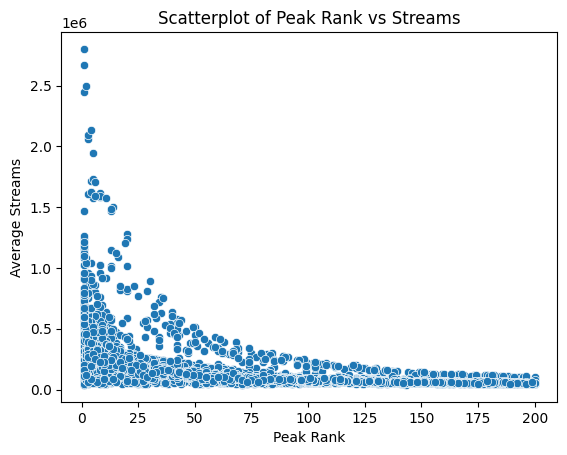

In [25]:
# Scatterplot of peak rank vs streams

sns.scatterplot(data=song_properties_df, x='peak_rank', y= 'streams')
plt.title("Scatterplot of Peak Rank vs Streams")
plt.xlabel("Peak Rank")
plt.ylabel("Average Streams")
plt.show()

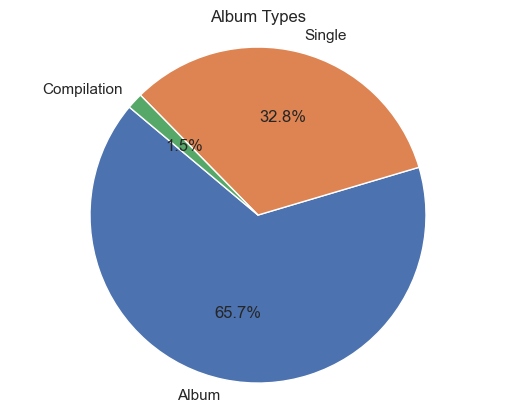

In [26]:
# Creating a pie chart to analyse the distribution of album type

sns.set(style='whitegrid')
sns.color_palette('pastel')  
plt.pie(song_properties_df['album_type'].value_counts(), labels=['Album', 'Single', 'Compilation'], autopct='%1.1f%%', startangle=140)
plt.title('Album Types')
plt.axis('equal')
plt.show()

C:\Users\ajaym\AppData\Local\Temp\ipykernel_22032\1517061001.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_properties_df['popularity'], hist=True, kde=False)


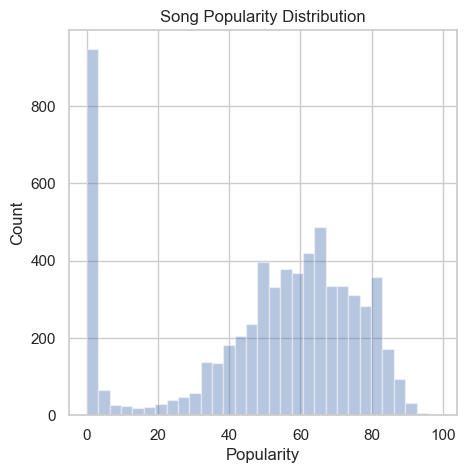

In [27]:
# Creating a distribution plot to analyse the popularity rating of songs

plt.figure(figsize=(5, 5))
sns.distplot(song_properties_df['popularity'], hist=True, kde=False)
plt.title("Song Popularity Distribution")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.show()

In [28]:
#Listing the most frequent popularity scores

song_properties_df['popularity'].value_counts().head()

popularity
0.0     747
63.0    143
62.0    140
55.0    140
61.0    138
Name: count, dtype: int64

In [29]:
# Removing Popularity column from data 

song_properties_df = song_properties_df.drop(columns='popularity')

In [30]:
# Listing the Top 10 most frequent words
 
all_words = ' '.join(song_properties_df['processed_track_name']).split()
word_freq = Counter(all_words)
top_10_words = word_freq.most_common(10)
top_10_words_df = pd.DataFrame(top_10_words, columns=['Word', 'Frequency'])
print(top_10_words_df)


       Word  Frequency
0      feat       1115
1      love        224
2  christma        129
3   version        119
4       lil        100
5     remix        100
6    remast         81
7      like         80
8    taylor         78
9      babi         74


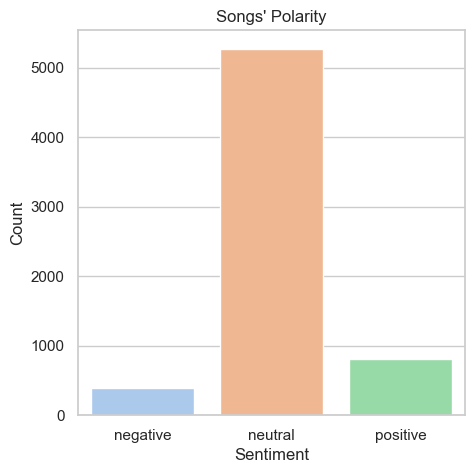

In [31]:
# Visualise the polarity of track names

cut = pd.cut(
    song_properties_df['sentiment'],
    [-np.inf, -0.01, 0.01, np.inf],
    labels=['negative', 'neutral', 'positive']
)

plt.figure(figsize=(5, 5))
g = sns.countplot(x=cut, palette="pastel")
plt.title("Songs' Polarity")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.show()

In [32]:
# Listing the top 5 most frequent peak ranks

song_properties_df['peak_rank'].value_counts().head()

peak_rank
1    144
2    108
8     94
3     85
4     77
Name: count, dtype: int64

C:\Users\ajaym\AppData\Local\Temp\ipykernel_22032\4280439805.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_properties_df[column], ax=axs[index])
C:\Users\ajaym\AppData\Local\Temp\ipykernel_22032\4280439805.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_properties_df[column],

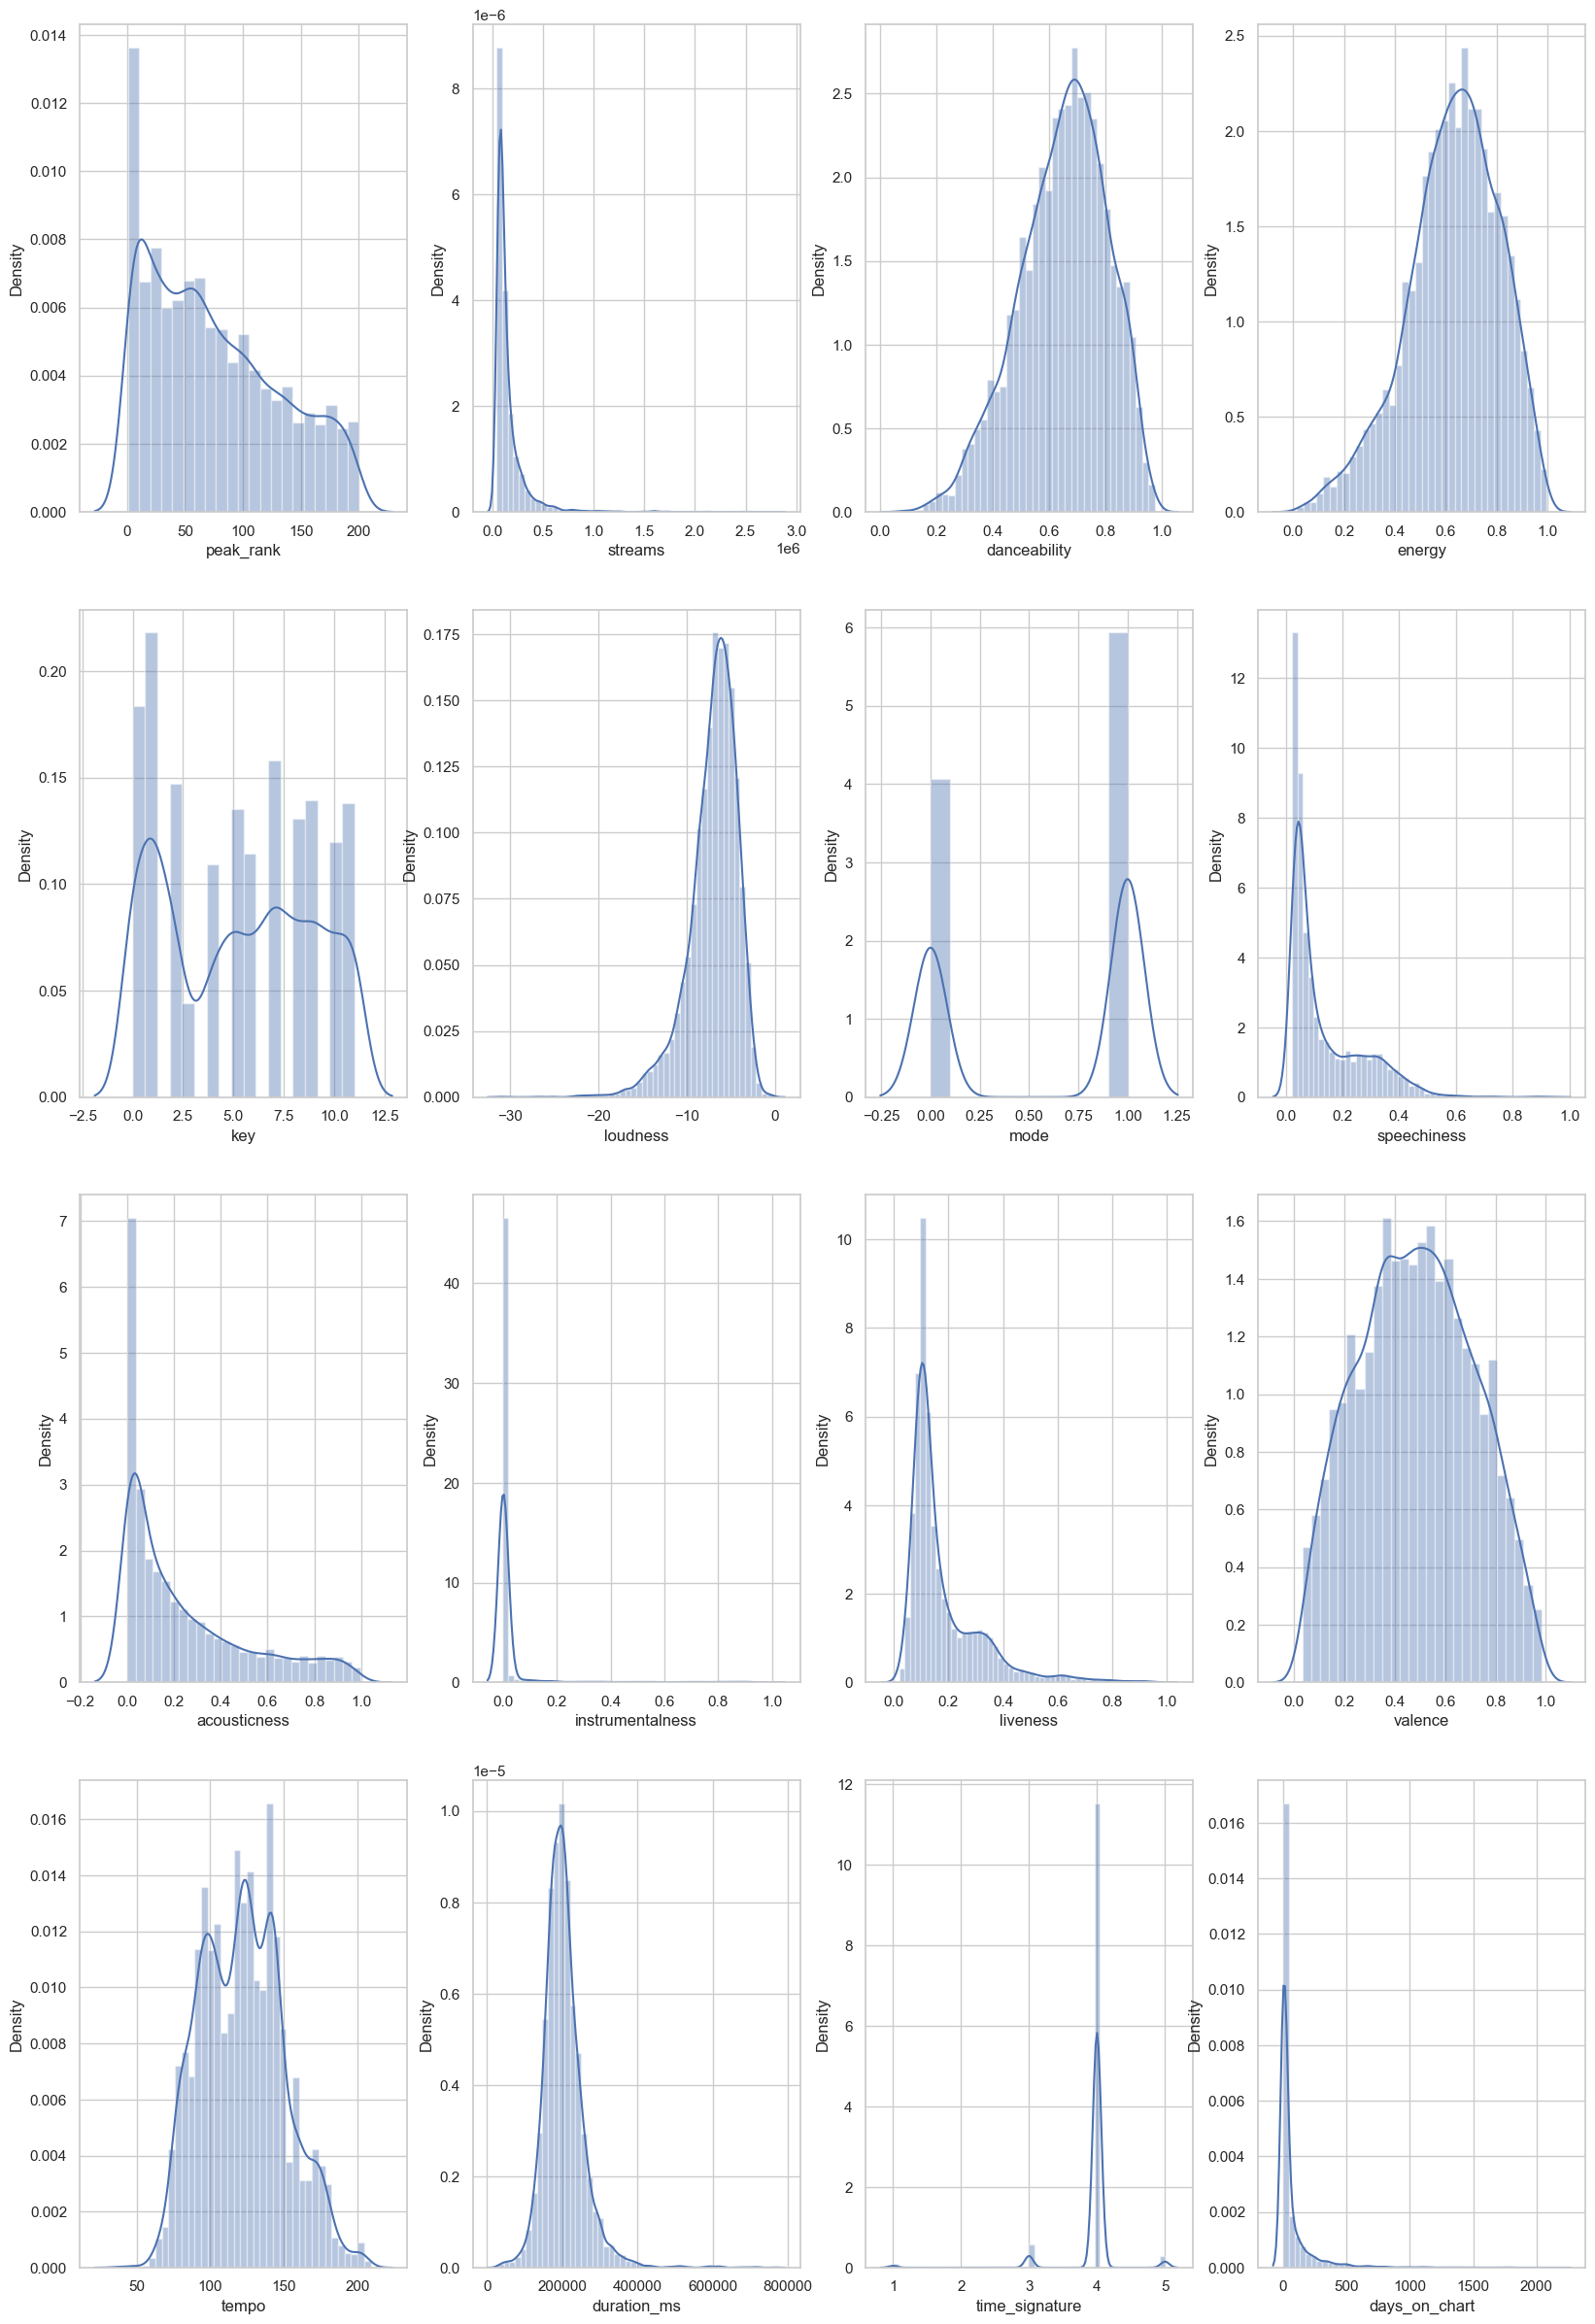

In [33]:
# Creating distribution plots for all numeric columns in the dataframe

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 30))
index = 0
axs = axs.flatten()
for column in song_properties_df.select_dtypes(include=['number']).iloc[:,:-1].columns:
    sns.distplot(song_properties_df[column], ax=axs[index])
    index += 1
plt.show()

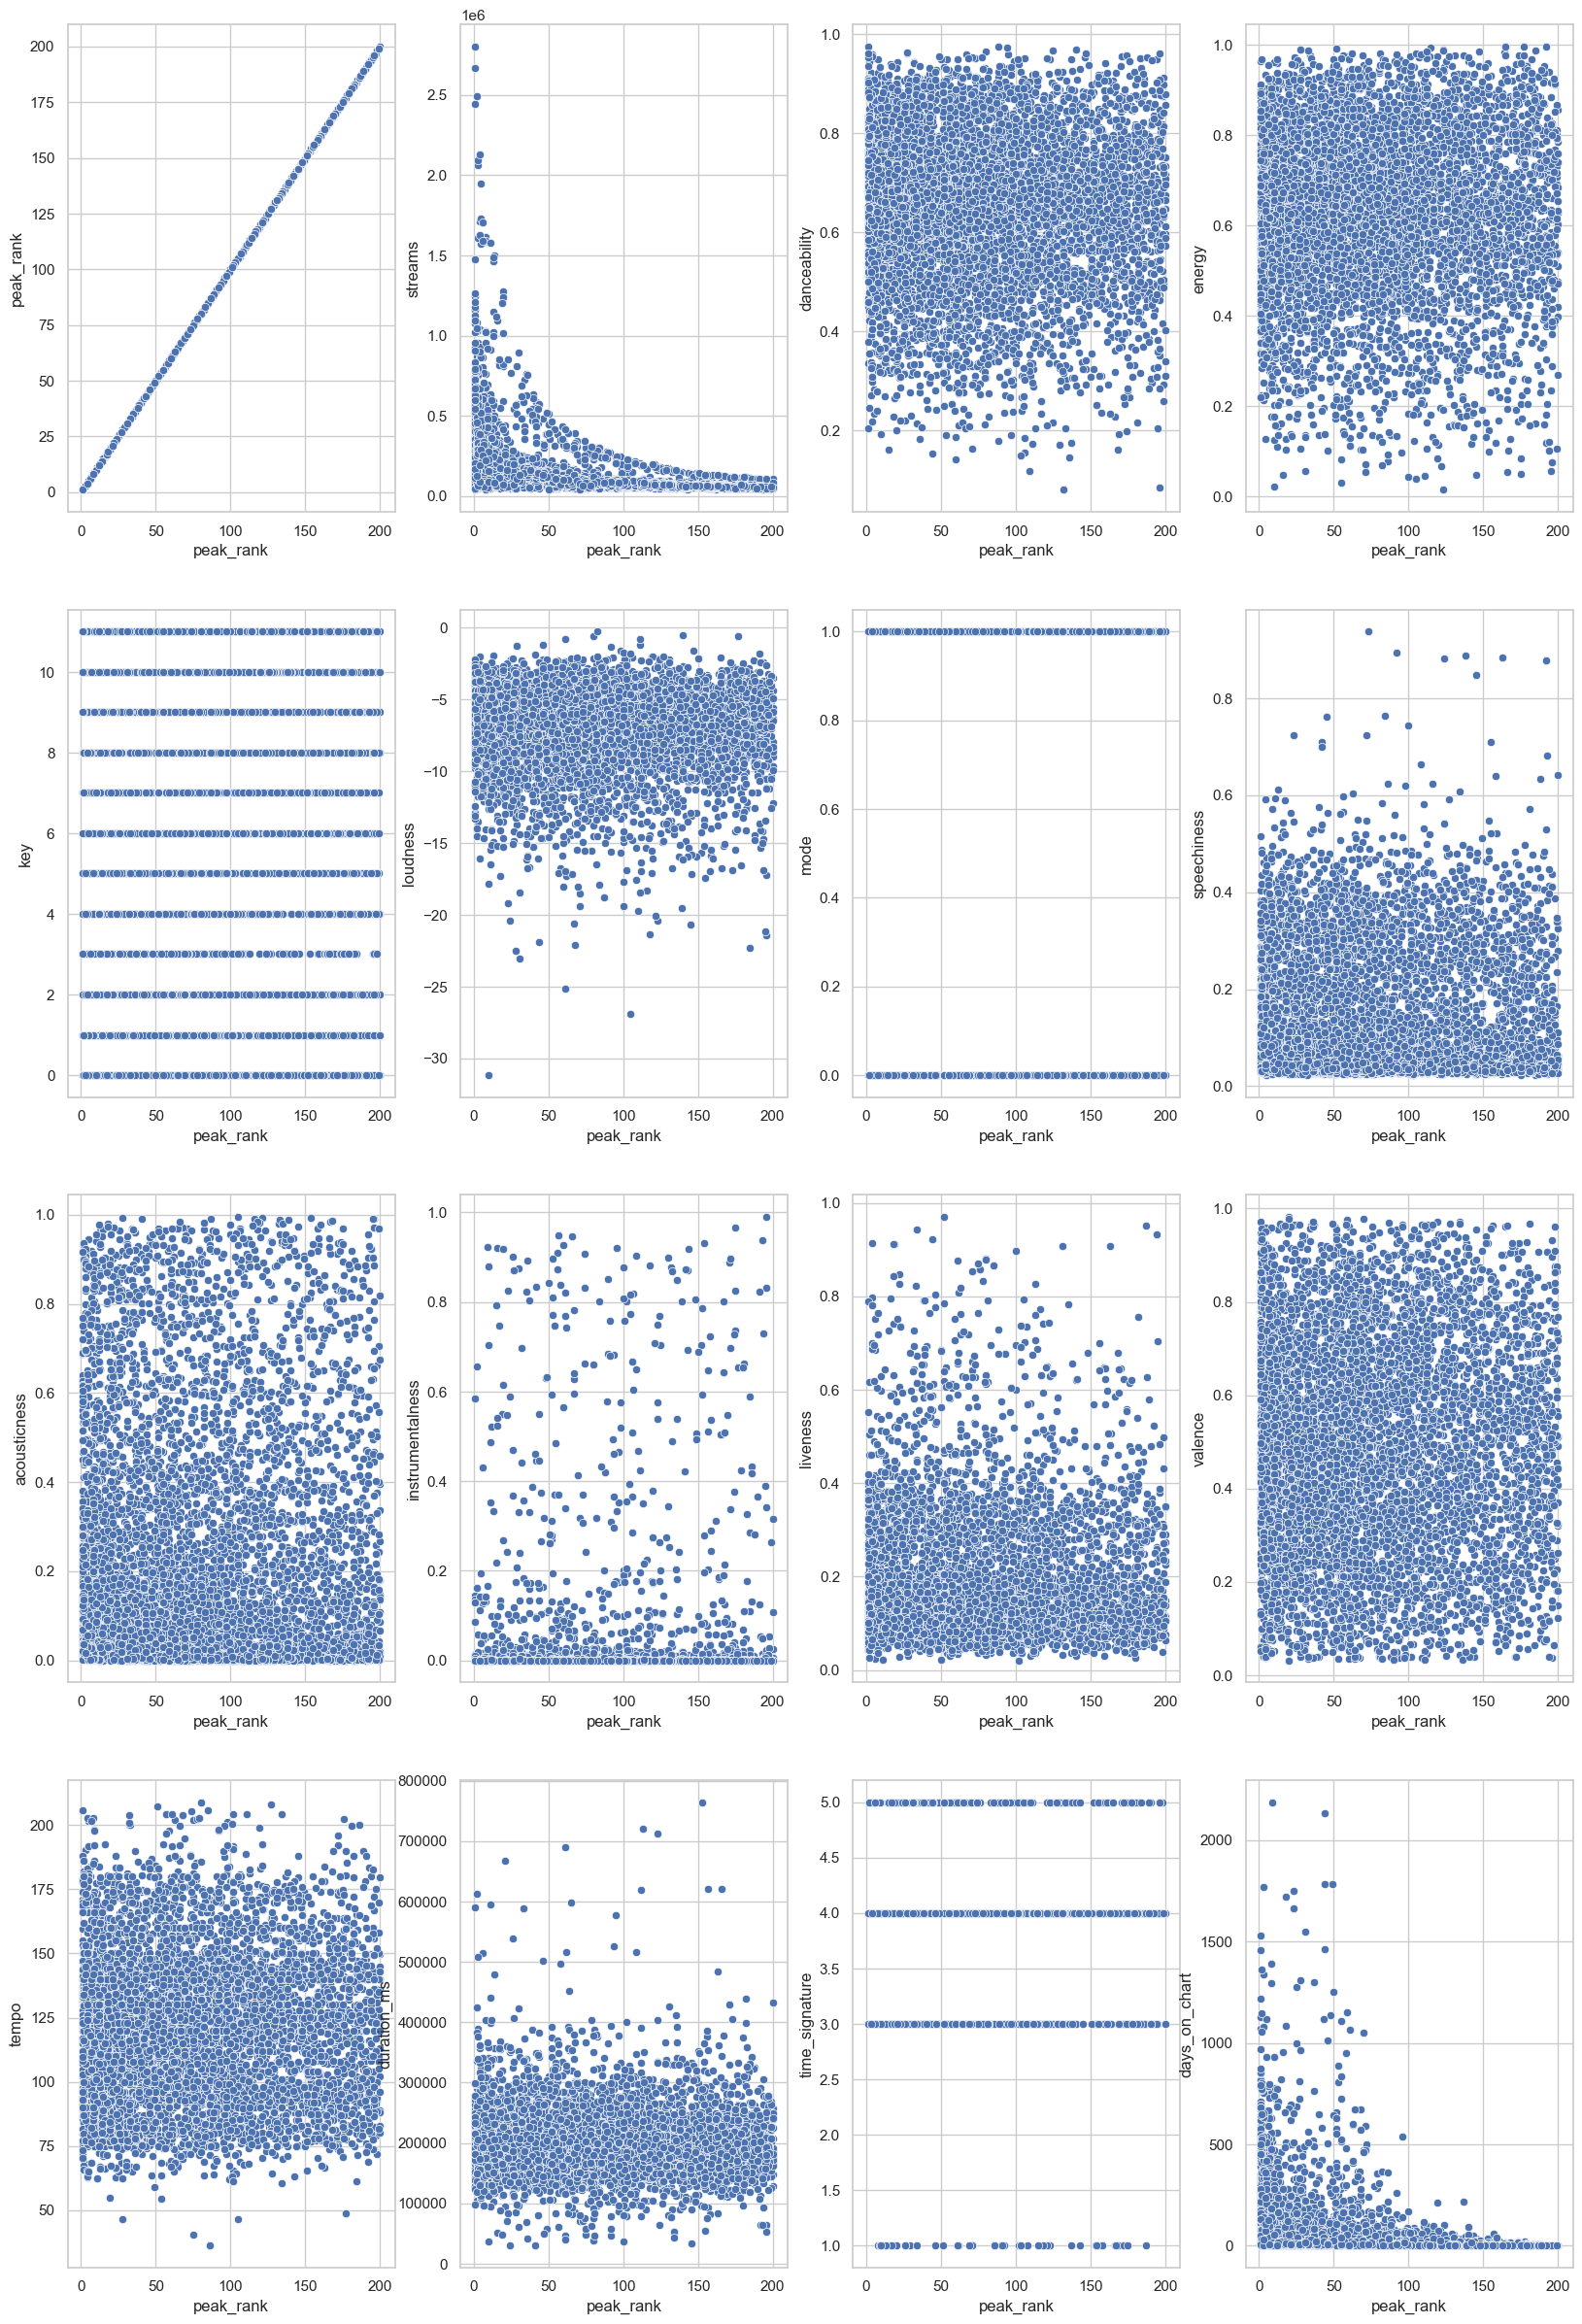

In [34]:
# Creating scatterplots for all numeric columns in the dataframe
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 30))
index = 0
axs = axs.flatten()
for k,v in song_properties_df.select_dtypes(include=['number']).iloc[:,:-1].items():
    sns.scatterplot(y=k, x='peak_rank', data=song_properties_df, ax=axs[index])
    index += 1
plt.show()

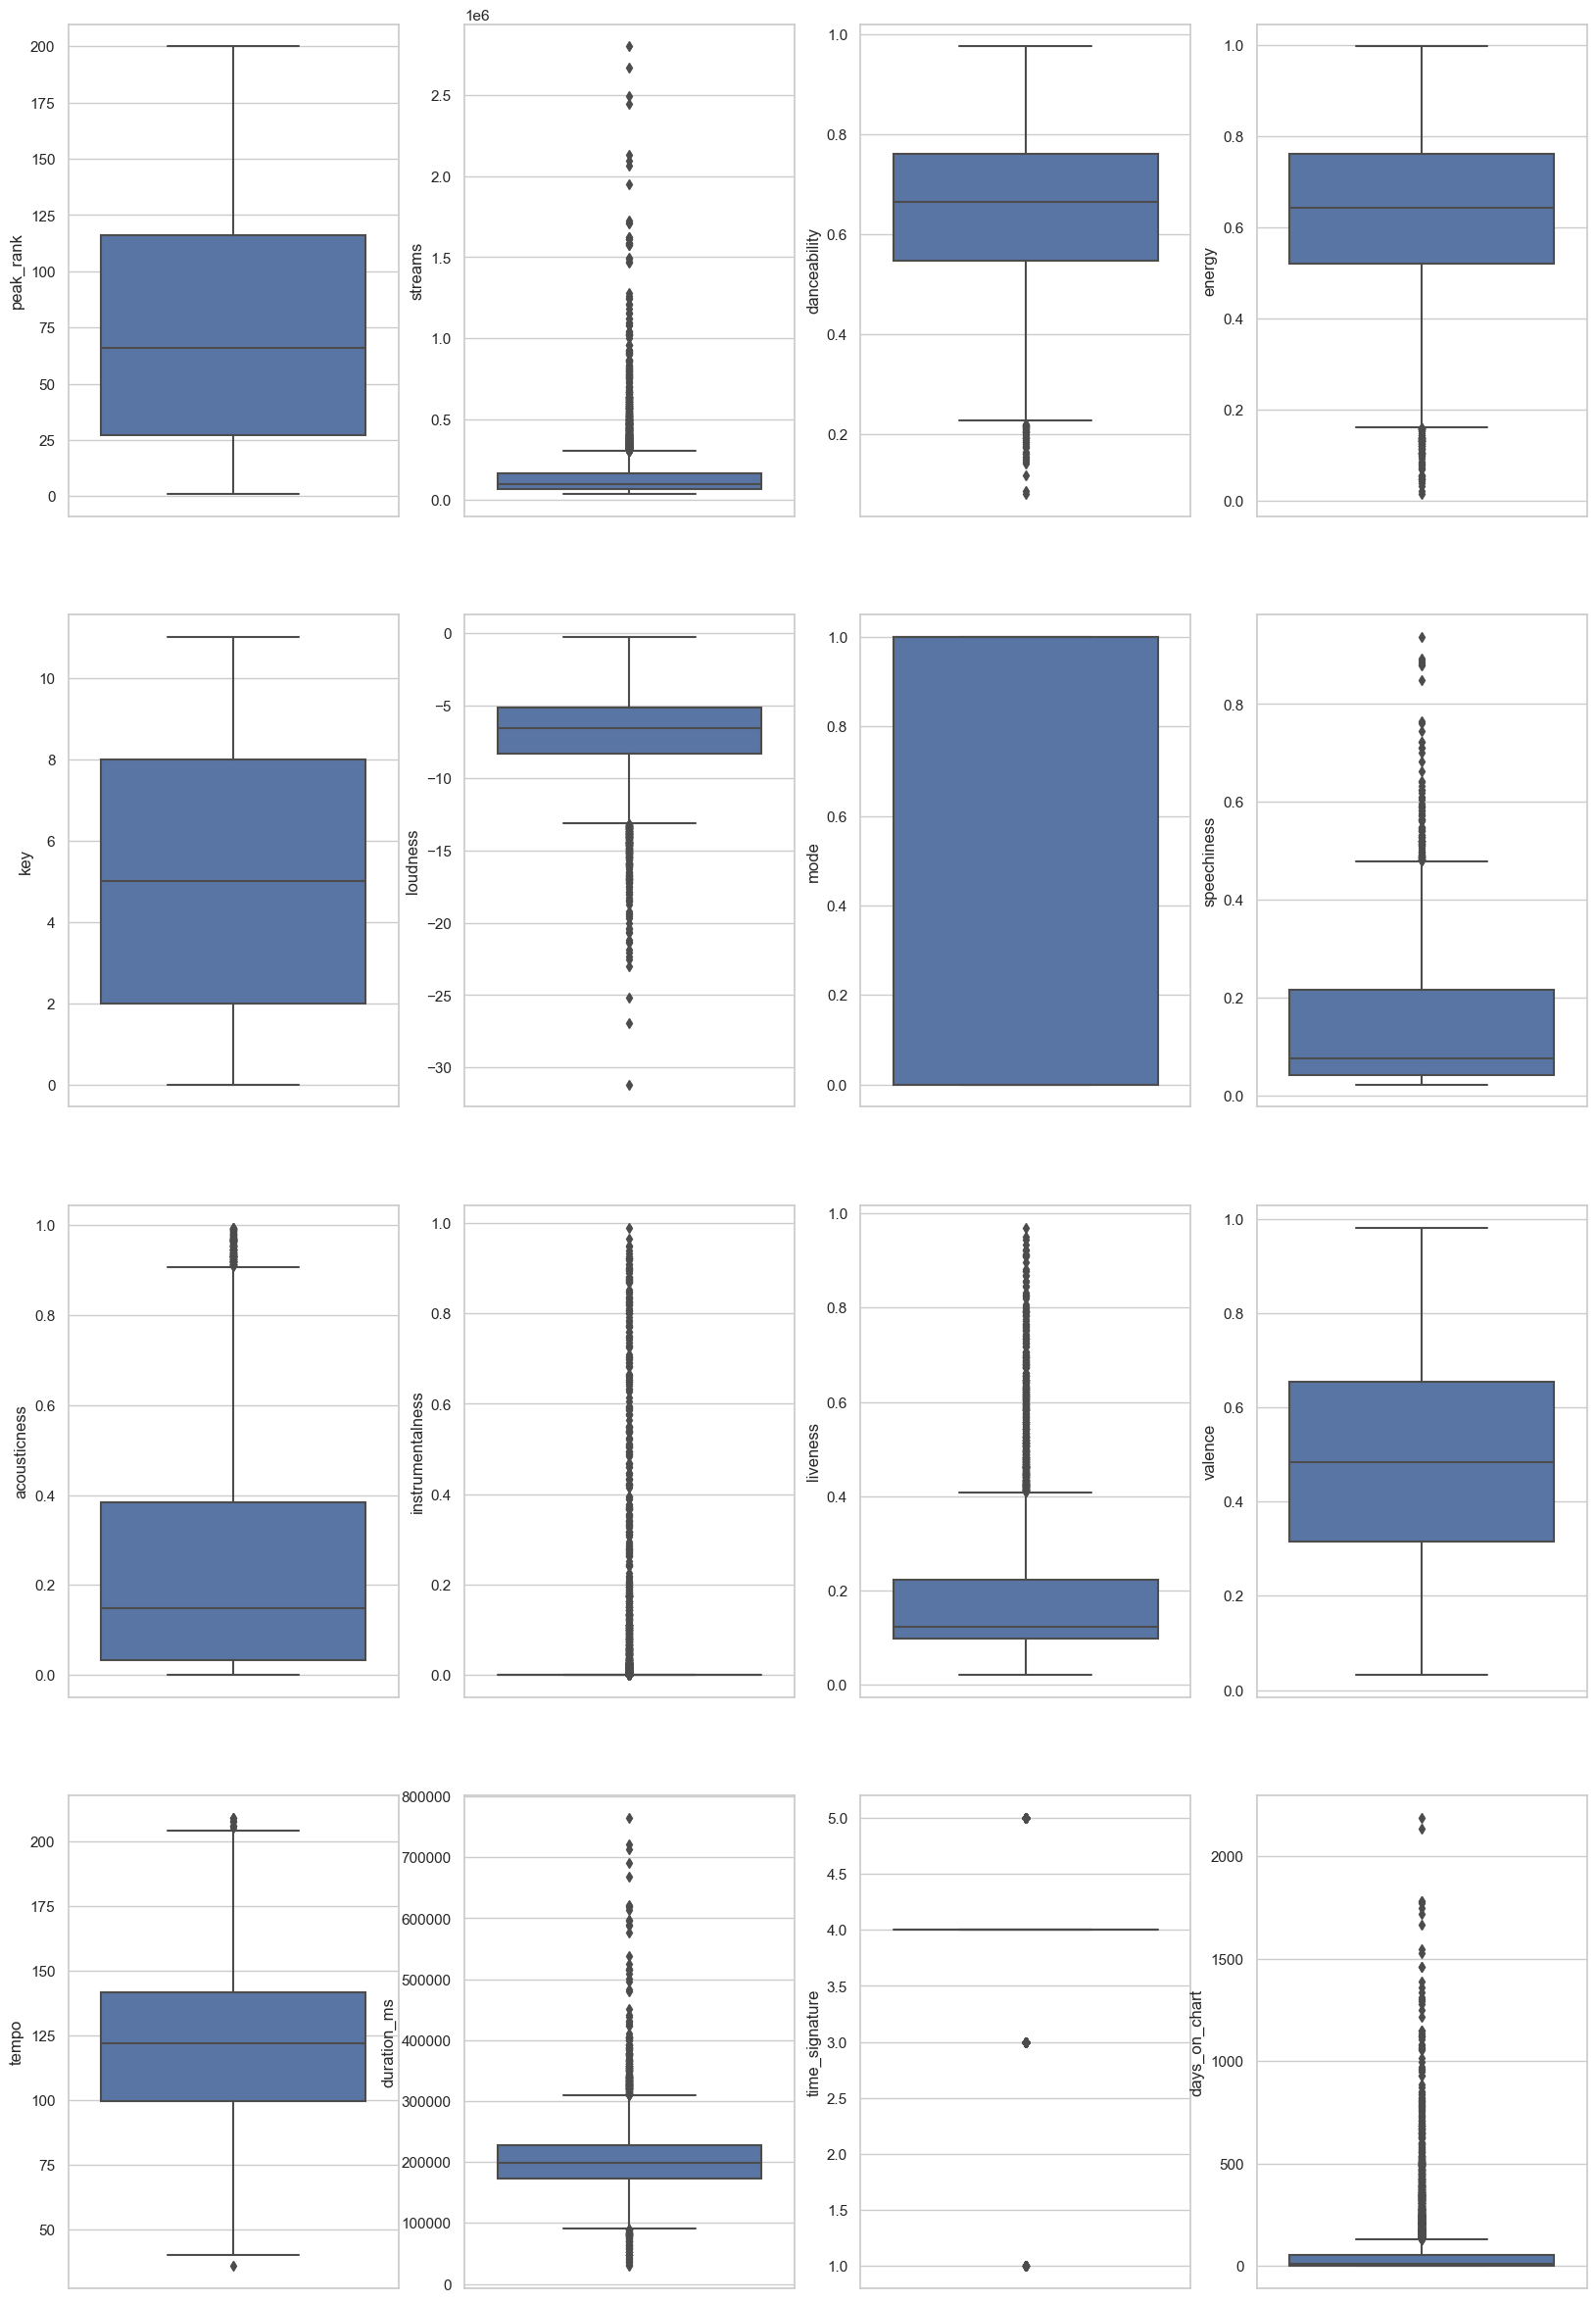

In [35]:
# Creating Box plots for outlier detection

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(20, 30))
index = 0
axs = axs.flatten()
for k,v in song_properties_df.select_dtypes(include=['number']).iloc[:,:-1].items():
    sns.boxplot(y=k, data=song_properties_df, ax=axs[index])
    index += 1
plt.show()

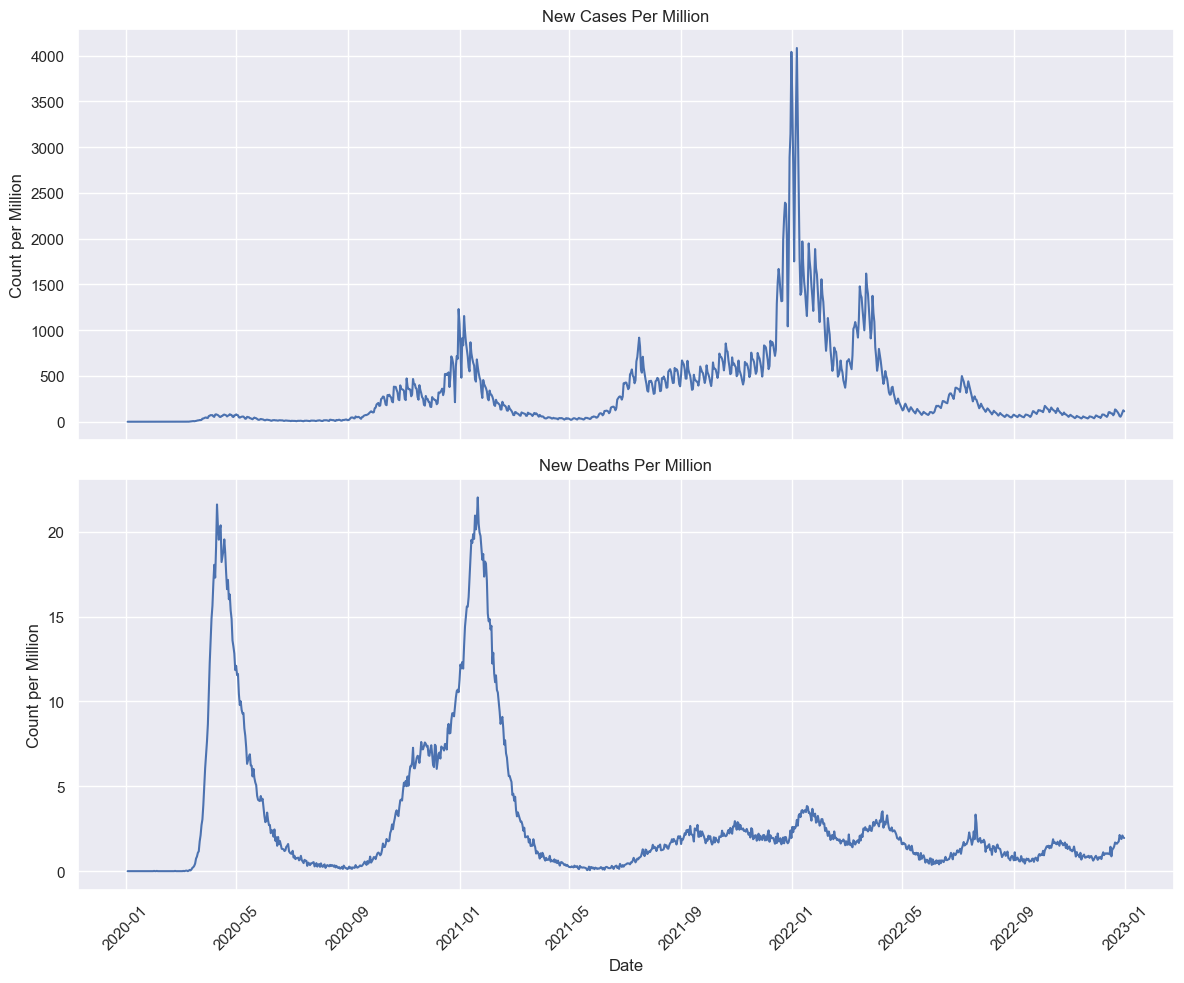

In [36]:
# Plotting new_cases_per_million and new_deaths_per_million

sns.set_style("darkgrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
sns.lineplot(data=uk_covid, x='date', y='new_cases_per_million', ax=axes[0])
axes[0].set_title('New Cases Per Million')
axes[0].set_ylabel('Count per Million')

sns.lineplot(data=uk_covid, x='date', y='new_deaths_per_million', ax=axes[1])
axes[1].set_title('New Deaths Per Million')
axes[1].set_ylabel('Count per Million')
axes[1].set_xlabel('Date')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Analysis

In [37]:
# Question 1: Is there any noticable change in the stream count across the three periods?

# Calculate average stream count for each period
average_streams_before = before_ld['streams'].mean()
average_streams_during = during_ld['streams'].mean()
average_streams_after = after_ld['streams'].mean()

# Print average stream counts for each period
print("Average Stream Counts:")
print(f"Before COVID: {average_streams_before:.2f}")
print(f"During COVID: {average_streams_during:.2f}")
print(f"After COVID: {average_streams_after:.2f}")

Average Stream Counts:
Before COVID: 106632.09
During COVID: 96679.81
After COVID: 100658.37


In [38]:
# Creating a list of months starting from March and ending with March

all_months = list(calendar.month_name)
start_index = all_months.index('March')
months_list = all_months[start_index:] + all_months[1:start_index+1]

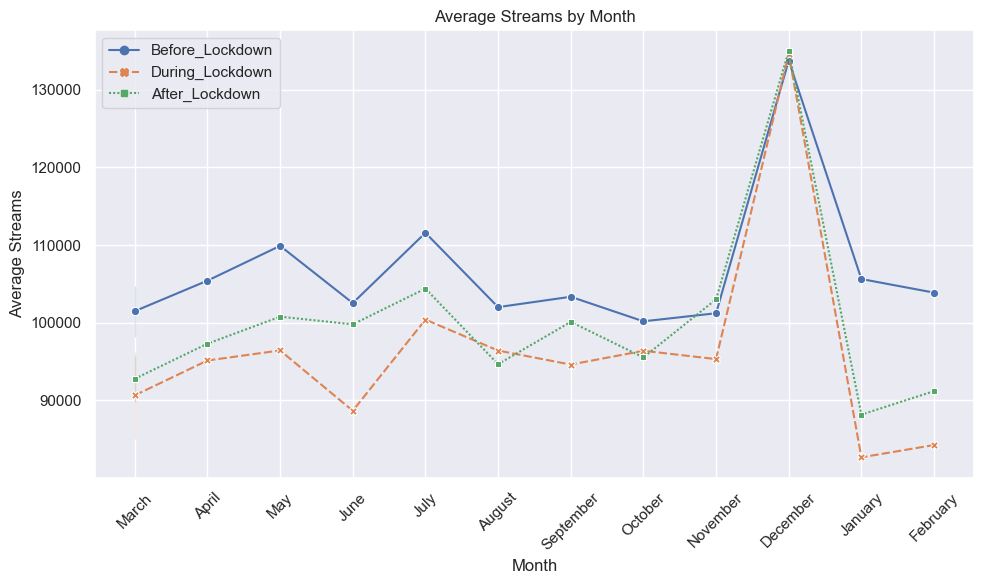

In [39]:
# Create line chart of average streams for the three periods

avg_streams = pd.DataFrame(index = months_list)
avg_streams.index.name = "Month"
avg_streams['Before_Lockdown'] = before_ld.groupby(before_ld['Date'].dt.to_period('M'))['streams'].mean().to_list()
avg_streams['During_Lockdown'] = during_ld.groupby(during_ld['Date'].dt.to_period('M'))['streams'].mean().to_list()
avg_streams['After_Lockdown'] = after_ld.groupby(after_ld['Date'].dt.to_period('M'))['streams'].mean().to_list()


plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_streams, markers=True, )
plt.title("Average Streams by Month")
plt.xlabel("Month")
plt.ylabel("Average Streams")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
# Checking if the difference in stream counts is statistically significant

# Perform Shapiro-Wilk test for normality on each group's residuals
shapiro_results = []
for column in avg_streams.columns:
    _, p_value = shapiro(avg_streams[column] - avg_streams[column].mean())  # Corrected residuals calculation
    shapiro_results.append((column, p_value))

print("Shapiro-Wilk Test for Normality:")
for group, p_value in shapiro_results:
    print(f"{group}: p-value = {p_value:.4f}")


print("\nBefore and During Lockdown")
# Levene Test for Homogeneity of Variances before and after covid
stat, p = levene(avg_streams['Before_Lockdown'], avg_streams['During_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")

# Performing Mann-Whitney U Test as normality was not observed between the groups
u_statistic, u_p_value = stats.mannwhitneyu(avg_streams['Before_Lockdown'], avg_streams['During_Lockdown'])
print("Mann-Whitney U Test Test:")
print(f"Mann-Whitney U Test statistic = {u_statistic}, p-value = {u_p_value}")

print("\nDuring and After Lockdown")
# Levene Test for Homogeneity of Variances before and after covid
stat, p = levene(avg_streams['After_Lockdown'], avg_streams['During_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")

# Performing Mann-Whitney U Test as normality was not observed between the groups
u_statistic, u_p_value = stats.mannwhitneyu(avg_streams['After_Lockdown'], avg_streams['During_Lockdown'])
print("Mann-Whitney U Test:")
print(f"Mann-Whitney U Test statistic = {u_statistic}, p-value = {u_p_value}")

print("\nBefore, During and After Lockdown")
# Levene Test for Homogeneity of Variances before, during and after covid
stat, p = levene(avg_streams['Before_Lockdown'], avg_streams['During_Lockdown'], avg_streams['After_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")


# Performing Kruskal-Wallis test on the three periods
kruskal_statistic, kruskal_p_value = kruskal(avg_streams['Before_Lockdown'], avg_streams['During_Lockdown'], avg_streams['After_Lockdown'])
print("Kruskal-Wallis Test:")
print(f"Kruskal statistic = {kruskal_statistic}, p-value = {kruskal_p_value}")



Shapiro-Wilk Test for Normality:
Before_Lockdown: p-value = 0.0004
During_Lockdown: p-value = 0.0006
After_Lockdown: p-value = 0.0010

Before and During Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 0.30925039540342725, p-value = 0.5832885753595216
Mann-Whitney U Test Test:
Mann-Whitney U Test statistic = 154.0, p-value = 0.0004024659086884892

During and After Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 0.0018401569096348628, p-value = 0.9661385016526437
Mann-Whitney U Test:
Mann-Whitney U Test statistic = 112.0, p-value = 0.16617010468287607

Before, During and After Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 0.18662739119063307, p-value = 0.8305505099292496
Kruskal-Wallis Test:
Kruskal statistic = 15.276923076923083, p-value = 0.0004815687574581442


In [41]:
# Question 2: Is there any noticable change in nostalgia across the three periods?

# Calculate average stream count for each period
average_nosta_before = before_ld['nostalgia'].mean()
average_nosta_during = during_ld['nostalgia'].mean()
average_nosta_after = after_ld['nostalgia'].mean()

# Print average stream counts for each period
print("Average Nostalgia:")
print(f"Before Lockdown: {average_nosta_before:.2f}")
print(f"During Lockdown: {average_nosta_during:.2f}")
print(f"After Lockdown: {average_nosta_after:.2f}")

Average Nostalgia:
Before Lockdown: 0.12
During Lockdown: 0.20
After Lockdown: 0.30


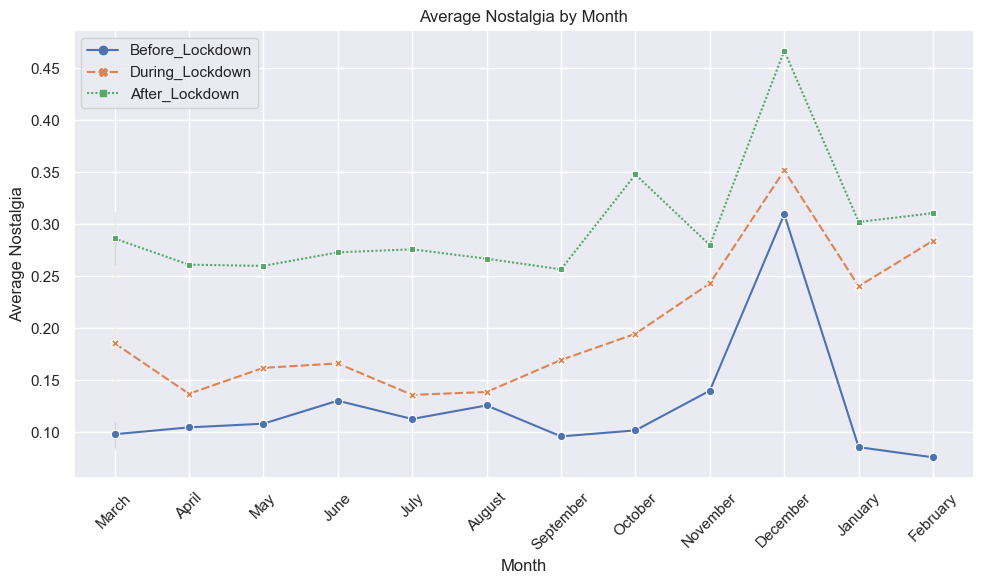

In [42]:
# Create line chart for average nostaliga across the three periods

avg_nosta = pd.DataFrame(index = months_list)
avg_nosta.index.name = "Month"
avg_nosta['Before_Lockdown'] = before_ld.groupby(before_ld['Date'].dt.to_period('M'))['nostalgia'].mean().to_list()
avg_nosta['During_Lockdown'] = during_ld.groupby(during_ld['Date'].dt.to_period('M'))['nostalgia'].mean().to_list()
avg_nosta['After_Lockdown'] = after_ld.groupby(after_ld['Date'].dt.to_period('M'))['nostalgia'].mean().to_list()


plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_nosta, markers=True)
plt.title("Average Nostalgia by Month")
plt.xlabel("Month")
plt.ylabel("Average Nostalgia")
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [43]:
# Checking if the difference in nostalgia is statistically significant

# Perform Shapiro-Wilk test for normality on each group's residuals
shapiro_results = []
for column in avg_nosta.columns:
    _, p_value = shapiro(avg_nosta[column] - avg_nosta[column].mean())  # Corrected residuals calculation
    shapiro_results.append((column, p_value))

print("Shapiro-Wilk Test for Normality:")
for group, p_value in shapiro_results:
    print(f"{group}: p-value = {p_value:.4f}")


print("\nBefore and During Lockdown")
# Levene Test for Homogeneity of Variances before and after covid
stat, p = levene(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")

# Performing  Two-Sample t-test
t_statistic, p_value = stats.ttest_ind(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'])
print("\nTwo-Sample t-test:")
print(f"T-statistic = {t_statistic}, p-value = {p_value}")

# Performing Mann-Whitney U Test as normality was not observed between the groups
u_statistic, u_p_value = stats.mannwhitneyu(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'])
print("Mann-Whitney U Test Test:")
print(f"Mann-Whitney U Test statistic = {u_statistic}, p-value = {u_p_value}")

print("\nDuring and After Lockdown")
# Levene Test for Homogeneity of Variances before and after covid
stat, p = levene(avg_nosta['After_Lockdown'], avg_nosta['During_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")

# Performing Two-Sample t-test
t_statistic, p_value = stats.ttest_ind(avg_nosta['During_Lockdown'], avg_nosta['After_Lockdown'],)
print("\nTwo-Sample t-test:")
print(f"T-statistic = {t_statistic}, p-value = {p_value}")

# Performing Mann-Whitney U Test as normality was not observed between the groups
u_statistic, u_p_value = stats.mannwhitneyu(avg_nosta['After_Lockdown'], avg_nosta['During_Lockdown'])
print("Mann-Whitney U Test:")
print(f"Mann-Whitney U Test statistic = {u_statistic}, p-value = {u_p_value}")

print("\nBefore, During and After Lockdown")
# Levene Test for Homogeneity of Variances before, during and after covid
stat, p = levene(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'], avg_nosta['After_Lockdown'])
print("\nLevene Test for Homogeneity of Variances:")
print(f"Test Statistic = {stat}, p-value = {p}")

# Performing One-Way ANOVA on the three periods
f_statistic, p_value = f_oneway(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'], avg_nosta['After_Lockdown'])
print("\nOne-Way ANOVA:")
print(f"F-statistic = {f_statistic}, p-value = {p_value}")

# Performing Kruskal-Wallis test on the three periods
kruskal_statistic, kruskal_p_value = kruskal(avg_nosta['Before_Lockdown'], avg_nosta['During_Lockdown'], avg_nosta['After_Lockdown'])
print("Kruskal-Wallis Test:")
print(f"Kruskal statistic = {kruskal_statistic}, p-value = {kruskal_p_value}")


Shapiro-Wilk Test for Normality:
Before_Lockdown: p-value = 0.0001
During_Lockdown: p-value = 0.5396
After_Lockdown: p-value = 0.0006

Before and During Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 2.157997506939299, p-value = 0.15481623946892903

Two-Sample t-test:
T-statistic = -2.8823251152215446, p-value = 0.008193244303654274
Mann-Whitney U Test Test:
Mann-Whitney U Test statistic = 26.0, p-value = 0.002936013789654769

During and After Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 1.597929897224143, p-value = 0.21833663750199647

Two-Sample t-test:
T-statistic = -3.7001208049250467, p-value = 0.0011199652421841296
Mann-Whitney U Test:
Mann-Whitney U Test statistic = 141.0, p-value = 0.004081478047545632

Before, During and After Lockdown

Levene Test for Homogeneity of Variances:
Test Statistic = 1.2938638930329422, p-value = 0.2866548557062492

One-Way ANOVA:
F-statistic = 23.85551556864814, p-value = 2.5313754647683444e-07
Kruskal-

In [44]:
# Analysing the reason for increase in streams and nostaligia during December of each year in the period.

decem_df = combined_df[(combined_df['Date'] >= '12/01/2019') & (combined_df['Date'] < '12/31/2019' )]
decem_df = pd.concat([decem_df, combined_df[(combined_df['Date'] >= '12/01/2020') & (combined_df['Date'] < '12/31/2020' )]], ignore_index = True)
decem_df = pd.concat([decem_df, combined_df[(combined_df['Date'] >= '12/01/2021') & (combined_df['Date'] < '12/31/2021' )]], ignore_index = True)
decem_df.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,Date,...,type,id,track_href,analysis_url,duration_ms,time_signature,album_type,popularity,release_date,nostalgia
0,190,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,148,423,54342,2019-12-01,...,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17,0
1,170,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,190,424,55770,2019-12-02,...,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17,0
2,157,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,170,425,58531,2019-12-03,...,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17,0
3,159,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,157,426,58531,2019-12-04,...,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17,0
4,100,spotify:track:25sgk305KZfyuqVBQIahim,Ava Max,Sweet but Psycho,Atlantic Records,1,159,427,97388,2019-12-05,...,audio_features,25sgk305KZfyuqVBQIahim,https://api.spotify.com/v1/tracks/25sgk305KZfy...,https://api.spotify.com/v1/audio-analysis/25sg...,187436,4,single,3,2018-08-17,0


In [45]:
# Filterting songs containing christmas related words

christmas_keywords = ['christmas', 'xmas', 'santa', 'tree', 'jingle', 'bell']
pattern = '|'.join(christmas_keywords)
filtered_df = decem_df[decem_df['track_name'].str.contains(pattern, case=False)]


In [46]:
# Selecting a single occurence of songs from the filtered dataframe

decem_songs = filtered_df.groupby('uri').agg(
    artist_names = ('artist_names', text_extract),
    track_name = ('track_name', text_extract),
    source = ('source', text_extract),
    album_type = ('album_type', text_extract),
    release_date = ('release_date', text_extract),
    peak_rank = ('peak_rank', 'min'),
    streams = ('streams', 'max'),
    danceability = ('danceability', 'mean'),
    energy = ('energy', 'mean'),
    key =  ('key', 'mean'),
    loudness =  ('loudness', 'mean'), 
    mode =  ('mode', 'mean'),
    speechiness =  ('speechiness', 'mean'),  
    acousticness =  ('acousticness', 'mean'),
    instrumentalness =  ('instrumentalness', 'mean'),
    liveness =  ('liveness', 'mean'),
    valence =  ('valence', 'mean'),
    tempo =  ('tempo', 'mean'),
    duration_ms =  ('duration_ms', 'mean'),
    time_signature =  ('time_signature', 'mean'),
    days_on_chart = ('days_on_chart', 'max')
).reset_index()

In [47]:
# Checking the of Christmas themed songs

print("The number of christmas themed songs is:", len(decem_songs))

The number of christmas themed songs is: 158


In [48]:
# Listing the top 10 most streamed songs during December

filtered_df[['artist_names',	'track_name', 'streams','Date']].sort_values(by='streams', ascending = False).head(10)

,artist_names,track_name,streams,Date
6757,Wham!,Last Christmas,2555381,2020-12-25
6727,Mariah Carey,All I Want for Christmas Is You,2444375,2020-12-25
6842,Brenda Lee,Rockin' Around The Christmas Tree,2243660,2020-12-25
12560,Wham!,Last Christmas,2220211,2021-12-25
6814,Michael Bublé,It's Beginning to Look a Lot like Christmas,2063886,2020-12-25
12531,Mariah Carey,All I Want for Christmas Is You,1919706,2021-12-25
10959,Bobby Helms,Jingle Bell Rock,1848012,2020-12-25
12645,Brenda Lee,Rockin' Around The Christmas Tree,1818732,2021-12-25
6756,Wham!,Last Christmas,1810023,2020-12-24
6726,Mariah Carey,All I Want for Christmas Is You,1760255,2020-12-24


In [49]:
# Listing Top 10 songs for the four years

combined_df[['artist_names',	'track_name', 'streams','Date']].sort_values(by='streams', ascending = False).head(10)

,artist_names,track_name,streams,Date
247055,Adele,Easy On Me,2801638,2021-10-15
123869,Wham!,Last Christmas,2669539,2022-12-25
123751,Wham!,Last Christmas,2555381,2020-12-25
125932,Brenda Lee,Rockin' Around The Christmas Tree,2492635,2022-12-25
123413,Mariah Carey,All I Want for Christmas Is You,2444375,2020-12-25
123532,Mariah Carey,All I Want for Christmas Is You,2410755,2022-12-25
125832,Brenda Lee,Rockin' Around The Christmas Tree,2243660,2020-12-25
123810,Wham!,Last Christmas,2220211,2021-12-25
200212,Bobby Helms,Jingle Bell Rock,2130871,2022-12-25
292098,Michael Bublé,It's Beginning to Look a Lot like Christmas,2093376,2022-12-25


In [50]:
# Comparison of average monthly stream count of Christmas themed songs vs all songs

print("The average stream count of the four year period is :", combined_df['streams'].mean())
print("The average stream count for the christmas songs is:", filtered_df['streams'].mean())

The average stream count of the four year period is : 101596.71240246407
The average stream count for the christmas songs is: 208288.34953876838


In [51]:
# Comparison of average nostalgia  of Christmas themed songs vs all songs

filtered_df.loc[:, 'nostalgia'] = filtered_df.apply(lambda row: 1 if (row['Date'] - row['release_date']).days > 1095 else 0, axis=1)
print("The nostalgia for the four year period is :", combined_df['nostalgia'].mean())
print("The nostalgia for the christmas songs is:", filtered_df['nostalgia'].mean())

The nostalgia for the four year period is : 0.23999315537303217
The nostalgia for the christmas songs is: 0.8708551483420593


In [52]:
# Question 3: Is there a visible trend in covid cases and the mood properties of songs
# Calculating the daily average of mood properties of songs

selected_df_grouped = selected_df.groupby('Date').agg(
    danceability = ('danceability', 'mean'),
    energy  = ('energy','mean'),
    valence  = ('valence', 'mean')
)

In [53]:
# Selecting the lockdown period in the UK for the analysis

uk_covid_ld = uk_covid.loc[(uk_covid['date'] >= '03/01/2020') & (uk_covid['date'] < '06/30/2022') ]

Correlation between New COVID Cases and Song Features:
                        danceability    energy   valence  \
danceability                1.000000  0.237719 -0.148917   
energy                      0.237719  1.000000  0.256599   
valence                    -0.148917  0.256599  1.000000   
new_cases_per_million      -0.439981  0.038461  0.222818   
new_deaths_per_million      0.011117 -0.276955 -0.147199   

                        new_cases_per_million  new_deaths_per_million  
danceability                        -0.439981                0.011117  
energy                               0.038461               -0.276955  
valence                              0.222818               -0.147199  
new_cases_per_million                1.000000                0.019933  
new_deaths_per_million               0.019933                1.000000  


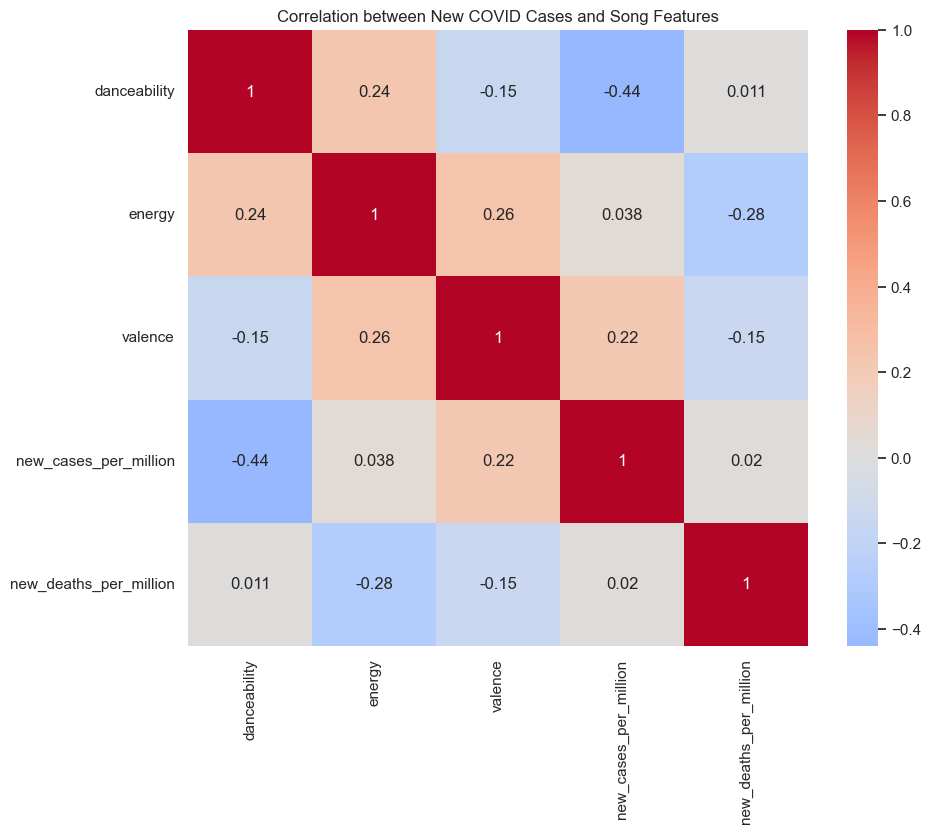

In [54]:
# Merging uk_covid and selected_df dataframes on the 'Date' column and generating a correlation matrix

merged_df = pd.merge(uk_covid_ld, selected_df_grouped, left_on='date', right_on='Date', how='inner')
merged_df = merged_df.set_index('date')

correlation_matrix = merged_df[['danceability', 'energy',  'valence', 'new_cases_per_million', 'new_deaths_per_million']].corr()
print("Correlation between New COVID Cases and Song Features:")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between New COVID Cases and Song Features")
plt.show()


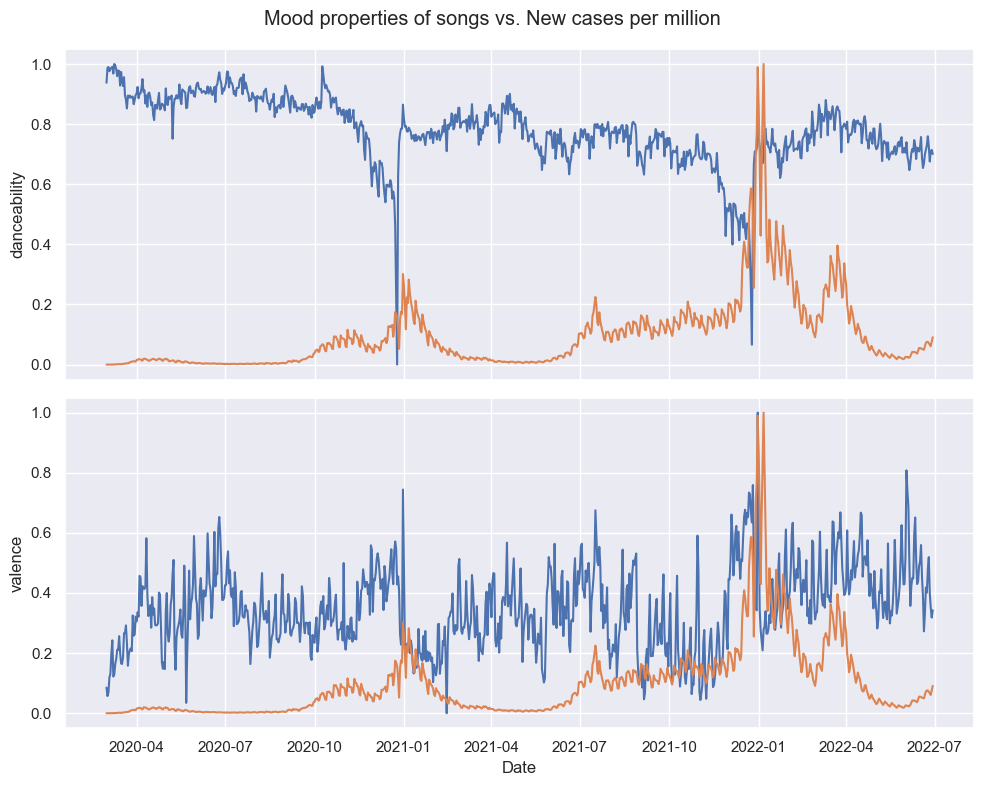

In [55]:
# Scaling values and plotting mood properties of songs vs new_cases_per_million

scaler = MinMaxScaler()
columns_to_scale = ['new_deaths_per_million', 'new_cases_per_million', 'danceability', 'energy', 'valence']
merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])
columns_to_plot = ['danceability',  'valence']
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 8), sharex=True)
for i, column in enumerate(columns_to_plot):
    axes[i].plot(merged_df.index, merged_df[column], merged_df['new_cases_per_million'])
    axes[i].set_ylabel(column)
axes[-1].set_xlabel('Date')
fig.suptitle('Mood properties of songs vs. New cases per million')
plt.tight_layout()
plt.show()